## Extracting Images to use for my final report as examples of how tabular-to-image data conversion works

### IGTD

In [1]:
import numpy as np
import pickle
with open('/scratch2-shared/erikep/Results/erik10_hq_8_12_Pearson/Results_imag.pkl', 'rb') as f:
    data = pickle.load(f)
    data_set_name = "pearson"
    file_name = "erik_hq_8_12"
    variance_thresh = 0
    norm = False
generated_images = np.transpose(data, (2, 0, 1))

In [5]:
from PIL import Image
import numpy as np
# data is your array

img = Image.fromarray(generated_images[0], 'L')
img.save('my.png')
img.show()



In [6]:
img

### DWTM

In [9]:
import cv2
import os
import pandas as pd
file_name = "erik10_hq_8_12"
def load_images(folder_path, train_range, test_range, validation_range):
    def read_image(file_path):
        img = cv2.imread(file_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    def read_images_in_range(r):
        images = []
        for i in r:
            file_name = os.path.join(folder_path, f"{i}.png")
            if os.path.exists(file_name):
                images.append(read_image(file_name))
            else:
                print(f"File {file_name} not found.")
        return np.array(images)

    train_set = read_images_in_range(train_range)
    test_set = read_images_in_range(test_range)
    validation_set = read_images_in_range(validation_range)

    return train_set, test_set, validation_set

with open("/home/jovyan/Tomics-CP-Chem-MoA/data_for_models/DWTM/" + file_name + "labels_moa_dict" +'_' + 'fold0'+ ".pkl", 'rb') as f:
    all_labels = pickle.load(f)
train_labels, valid_labels, test_labels, dict_moa, dict_indexes = all_labels

with open('/home/jovyan/Tomics-CP-Chem-MoA/data_for_models/DWTM_erik10_hq_8_12_splits.pkl', 'rb') as f:
    index_splits = pickle.load(f)
labels = pd.concat([train_labels, valid_labels, test_labels], axis=0).reset_index(drop=True)

for fold_int in range(4,5):
    print(f'Fold Iteration: {fold_int}')
    index_split_n = index_splits[fold_int]
    # split generated images into train, test and validation
    train_range = index_split_n["train"]
    valid_range = index_split_n["valid"]
    test_range = index_split_n["test"]

    # split generated labels into train, test and validation
    train_labels = labels.iloc[index_split_n["train"]].reset_index(drop=True)
    valid_labels = labels.iloc[index_split_n["valid"]].reset_index(drop=True)
    test_labels = labels.iloc[index_split_n["test"]].reset_index(drop=True)
    # checking that the number of images and labels are the same
    # Example usage:
    folder_path = '/scratch2-shared/erikep/DWTM/ImageDataset/'
    #train_range = range(dict_indexes["train"][0], dict_indexes["train"][1]+1)  # Images 1-100 for training
    #validation_range = range(dict_indexes["valid"][0],dict_indexes["valid"][1]+1)  # Images 101-125 for testing
    #test_range = range(dict_indexes["test"][0], dict_indexes["test"][1]+1)  # Images 126-150 for validation

    train_images, test_images, valid_images = load_images(folder_path, train_range, test_range, valid_range)


Fold Iteration: 4


In [22]:
img = Image.fromarray(train_images[133], 'RGB')
img.save('my.png')
img.show()


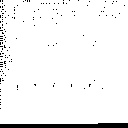

In [23]:
img

### DeepInsight

Begin Training
Fold Iteration: 0
passed veracity test!
pre-processing data!
extracting training transcriptomes
extracting validation transcriptomes
extracting test transcriptomes
normalization method used:  QuantileTransformer(n_quantiles=100, output_distribution='normal',
                    random_state=0)
passed veracity test!
Fitting Image Transformer...


/home/jovyan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


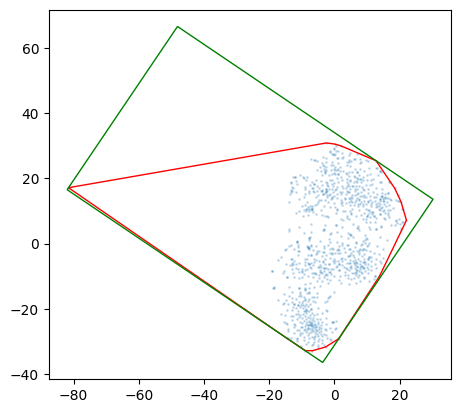

Transforming...


In [3]:


# Import Statements
import pandas as pd
import numpy as np
import datetime
import time
import torch
import torch.nn as nn
import neptune.new as neptune
from sklearn.manifold import TSNE
import time
from DeepInsight_Image_Transformer import ImageTransformer
import sys
sys.path.append('/home/jovyan/Tomics-CP-Chem-MoA/05_Global_Tomics_CP_CStructure/')
from Erik_alll_helper_functions import (
    apply_class_weights_CL,  
    create_splits, 
    val_vs_train_loss,
    val_vs_train_accuracy, 
    program_elapsed_time, 
    create_terminal_table, 
    upload_to_neptune, 
    different_loss_functions, 
    set_bool_hqdose, 
    set_bool_npy, 
    adapt_training_loop, 
    adapt_test_loop,
    checking_veracity_of_data,
    LogScaler,
    pre_processing,
    accessing_all_folds_csv
)

start = time.time()
now = datetime.datetime.now()
now = now.strftime("%d_%m_%Y-%H:%M:%S")
print("Begin Training")
model_name = "DeepInsight"
max_epochs = 1
            
    

# Downloading all relevant data frames and csv files ----------------------------------------------------------

# clue column metadata with columns representing compounds in common with SPECs 1 & 2
clue_sig_in_SPECS = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_sig_in_SPECS1&2.csv', delimiter = ",")

# clue row metadata with rows representing transcription levels of specific genes
clue_gene = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_geneinfo_beta.txt', delimiter = "\t")


class DI_Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, dict_moa):
        self.X = X
        self.y = y
        self.dict_moa = dict_moa

    def __getitem__(self, index):
        label = self.dict_moa[self.y[index]]
        return self.X[index], torch.tensor(label, dtype=torch.float)

    def __len__(self):
        return len(self.X)


# not deep   50x50
class DeepInsight_Model(nn.Module):
    def __init__(self):
        super(DeepInsight_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p= 0.23753380635366567)
        self.fc1 = nn.Linear(in_features=64*25*25, out_features=323)
        self.fc2 = nn.Linear(in_features=323, out_features= 654)
        self.fc3 = nn.Linear(in_features=654, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x
# ------------------------------------------------------------------------------------------------------------------------------
'''
file = input("Which file would you like to use? (Options: tian10, erik10, erik10_hq, erik10, erik10_hq_dos, erik10_dos, cyc_adr, cyc_dop):")
variance_threshold = input("What variance threshold would you like to use? (Options: 0 - 1.2):")
normalize = input("Would you like to normalize the data? (Options: True, False):")
'''  

file_name = "erik10_hq_8_12"
for fold_int in range(0,1):
    print(f'Fold Iteration: {fold_int}')
    training_set, validation_set, test_set = accessing_all_folds_csv(file_name, fold_int)
    hq, dose = set_bool_hqdose(file_name)
    L1000_training, L1000_validation, L1000_test = create_splits(training_set, validation_set, test_set, hq = hq, dose = dose)
    checking_veracity_of_data(file_name, L1000_training, L1000_validation, L1000_test)
    variance_thresh = 0
    normalize_c = 'False'
    npy_exists, save_npy = set_bool_npy(variance_thresh, normalize_c, five_fold = 'True')
    df_train_features, df_val_features, df_train_labels, df_val_labels, df_test_features, df_test_labels, dict_moa = pre_processing(L1000_training, L1000_validation, L1000_test, 
            clue_gene, 
            npy_exists = npy_exists,
            use_variance_threshold = variance_thresh, 
            normalize = normalize_c, 
            save_npy = save_npy,
            data_subset = file_name)
    checking_veracity_of_data(file_name, df_train_labels, df_val_labels, df_test_labels)

    df_train_labels_moa = df_train_labels
    # save moa labels, remove compounds
    df_train_labels = df_train_labels["moa"]
    df_val_labels = df_val_labels["moa"]
    df_test_labels = df_test_labels["moa"]

    X_train = df_train_features.to_numpy().astype(np.float32)
    X_val = df_val_features.to_numpy().astype(np.float32)
    y_train = df_train_labels.values
    y_val = df_val_labels.values
    X_test = df_test_features.to_numpy().astype(np.float32)
    y_test = df_test_labels.values


    ln = LogScaler()
    X_train_norm = ln.fit_transform(df_train_features.to_numpy().astype(float))
    X_val_norm = ln.transform(df_val_features.to_numpy().astype(float))
    X_test_norm = ln.transform(df_test_features.to_numpy().astype(float))


    # In[51]:
    #import umap 

    distance_metric = 'cosine'
    reducer = TSNE(
        n_components=2,
        metric=distance_metric,
        init='random',
        learning_rate='auto',
        perplexity=5,
        n_jobs=-1
    )


    pixel_size = (50,50)
    it = ImageTransformer( 
        pixels=pixel_size)



    # In[53]:

    # fitting Image Transformer
    print("Fitting Image Transformer...")
    it.fit(X_train, plot=True)
    print("Transforming...")
    X_train_img = it.transform(X_train_norm)
    X_val_img = it.transform(X_val_norm)
    X_test_img = it.transform(X_test_norm)


In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

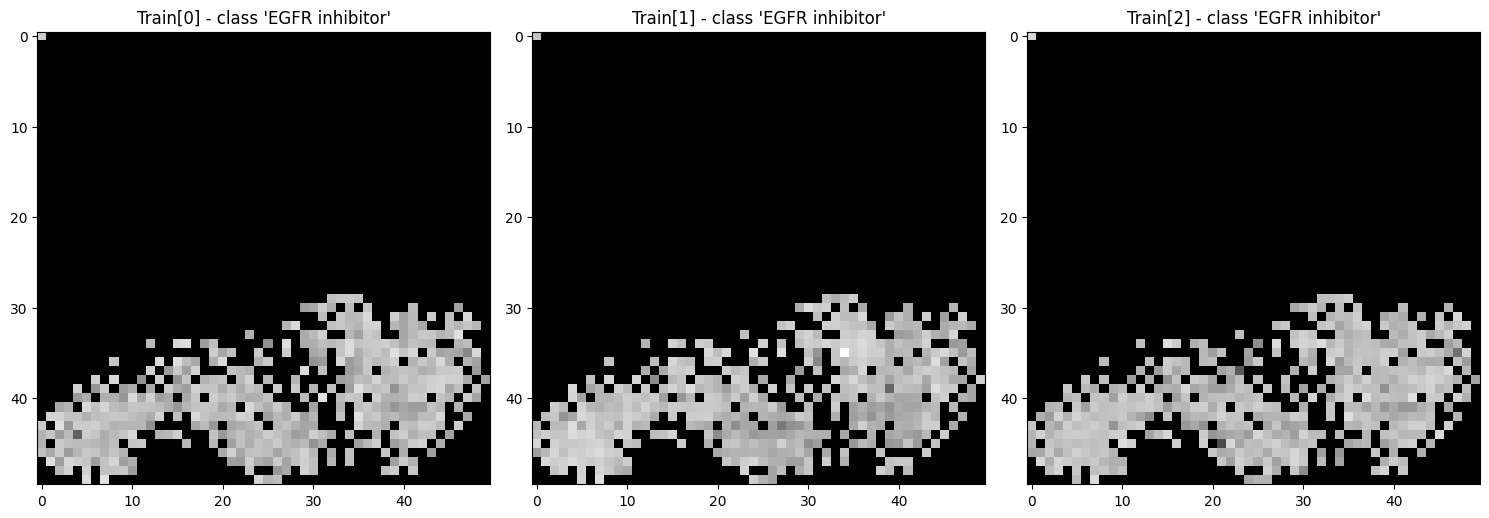

In [5]:
fig